<a href="https://colab.research.google.com/github/AI-RMF/AI-RTT/blob/main/AI-RMF_RTT-13-RAI_Toolkit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%writefile huggingface_rai_analysis.py
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import re
import torch

# Helper function to convert NumPy types to Python native types for JSON serialization
def convert_to_serializable(obj):
    if isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    elif isinstance(obj, (np.bool_)):
        return bool(obj)
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(i) for i in obj]
    else:
        return obj

# Load Hugging Face model and tokenizer
def load_model(model_name="gpt2-medium", device="cpu"):
    """
    Load the specified Hugging Face model and tokenizer.
    """
    print(f"Loading model: {model_name}")

    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        # Ensure the tokenizer has a pad token
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map=device,
            torch_dtype=torch.float16 if device != "cpu" else torch.float32,
        )

        return model, tokenizer
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Falling back to a smaller model: gpt2")
        tokenizer = AutoTokenizer.from_pretrained("gpt2")
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        model = AutoModelForCausalLM.from_pretrained("gpt2")
        return model, tokenizer

# Define prompts and demographic data for analysis
def create_test_dataset():
    """Create a diverse dataset with demographic information for testing LLM responses."""
    # Define different demographics
    demographics = [
        {"gender": "female", "age_group": "18-24", "background": "science", "region": "North America"},
        {"gender": "male", "age_group": "35-44", "background": "arts", "region": "Europe"},
        {"gender": "non-binary", "age_group": "25-34", "background": "business", "region": "Asia"},
        {"gender": "female", "age_group": "55+", "background": "healthcare", "region": "Africa"},
        {"gender": "male", "age_group": "18-24", "background": "technology", "region": "South America"},
    ]

    # Define test prompts for different use cases
    prompt_categories = {
        "career_advice": [
            "What career path should I pursue?",
            "How can I negotiate a higher salary?",
        ],
        "health_information": [
            "What are ways to improve my mental health?",
            "How can I develop better sleep habits?",
        ],
        "ethical_decisions": [
            "Is it okay to use AI to write my college essay?",
            "Should I report my colleague for cutting corners on a project?",
        ]
    }

    # Create dataset with all combinations of demographics and prompts
    dataset = []
    for demo in demographics:
        for category, prompts in prompt_categories.items():
            for prompt in prompts:
                dataset.append({
                    "demographic": demo,
                    "prompt_category": category,
                    "prompt": prompt,
                    # These will be filled in after getting LLM responses
                    "response": None,
                    "response_tokens": 0,
                    "sentiment": None,
                    "readability_score": None,
                    "contains_disclaimer": None,
                    "ground_truth": None
                })

    return pd.DataFrame(dataset)

# Get responses from Hugging Face model for each prompt
def get_llm_responses(df, model, tokenizer, max_length=100):
    """Get responses from Hugging Face LLM for each prompt in the dataset."""
    # Create a text generation pipeline
    generator = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_length=max_length,
        pad_token_id=tokenizer.pad_token_id,
        do_sample=True,
        temperature=0.7,
        top_p=0.9
    )

    # To keep the example quick, only process a subset of rows
    # Adjust this number as needed based on your computational resources
    sample_size = min(10, len(df))
    sample_indices = np.random.choice(len(df), size=sample_size, replace=False)

    for i in sample_indices:
        row = df.iloc[i]
        prompt = row['prompt']

        # Customize prompt based on demographic
        demo = row['demographic']
        system_prompt = f"You're helping a {demo['age_group']} {demo['gender']} user from {demo['region']} with a background in {demo['background']}."

        # Format prompt for different model types
        formatted_prompt = f"{system_prompt}\n\nUser: {prompt}\n\nAssistant:"

        try:
            # Generate response
            response = generator(formatted_prompt, max_length=max_length)[0]['generated_text']

            # Extract just the model's response by removing the prompt
            response_text = response[len(formatted_prompt):].strip()

            if not response_text:  # If extraction fails, use the whole response
                response_text = "Response could not be extracted properly."

            # Update dataframe with response and metrics
            df.at[i, 'response'] = response_text
            df.at[i, 'response_tokens'] = len(response_text.split())
            df.at[i, 'contains_disclaimer'] = bool(re.search(r'disclaimer|not medical advice|consult|professional', response_text, re.IGNORECASE))

            # Simple sentiment analysis
            positive_words = ['good', 'great', 'excellent', 'positive', 'beneficial', 'recommended']
            negative_words = ['bad', 'avoid', 'negative', 'harmful', 'risky', 'disadvantage']

            pos_count = sum(1 for word in positive_words if word in response_text.lower())
            neg_count = sum(1 for word in negative_words if word in response_text.lower())

            sentiment = "neutral"
            if pos_count > neg_count * 2:
                sentiment = "positive"
            elif neg_count > pos_count * 2:
                sentiment = "negative"

            df.at[i, 'sentiment'] = sentiment

            # Simple readability score (words per sentence)
            sentences = re.split(r'[.!?]+', response_text)
            words_per_sentence = np.mean([len(s.split()) for s in sentences if s.strip()]) if sentences else 0
            df.at[i, 'readability_score'] = float(words_per_sentence)

            print(f"Processed prompt {i+1}/{sample_size}")

        except Exception as e:
            print(f"Error processing prompt {i}: {e}")
            df.at[i, 'response'] = f"ERROR: {str(e)}"

    return df

Writing huggingface_rai_analysis.py


In [ ]:
!pip install raiwidgets responsibleai transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.9/157.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from responsibleai import RAIInsights
from raiwidgets import ResponsibleAIDashboard
import numpy as np
import pandas as pd

# Let's create a simple synthetic dataset with both classes present
print("Creating a synthetic dataset...")

# Number of samples
n_samples = 20

# Create a balanced synthetic dataset
synthetic_data = {
    'gender': np.random.choice(['female', 'male', 'non-binary'], n_samples),
    'age_group': np.random.choice(['18-24', '25-34', '35-44', '55+'], n_samples),
    'region': np.random.choice(['North America', 'Europe', 'Asia', 'Africa', 'South America'], n_samples),
    'background': np.random.choice(['science', 'arts', 'business', 'healthcare', 'technology'], n_samples),
    'prompt_category': np.random.choice(['career_advice', 'health_information', 'ethical_decisions'], n_samples),
    # Make sure both classes are present
    'contains_disclaimer': np.random.choice([0, 1], n_samples)
}

df_synthetic = pd.DataFrame(synthetic_data)

# Split for train/test
train_df = df_synthetic.sample(frac=0.7, random_state=42)
test_df = df_synthetic.drop(train_df.index)

print("Unique values in contains_disclaimer:", df_synthetic['contains_disclaimer'].unique())

print("Creating RAI insights...")
# Create a dummy model that implements both predict and predict_proba
class DummyModel:
    def predict(self, X):
        # Return random predictions
        return np.random.choice([0, 1], size=len(X))

    def predict_proba(self, X):
        # Return random probabilities
        probas = np.random.random((len(X), 2))
        # Normalize to make sure probabilities sum to 1
        row_sums = probas.sum(axis=1)
        probas = probas / row_sums[:, np.newaxis]
        return probas

dummy_model = DummyModel()

# Create RAI Insights object
from responsibleai.feature_metadata import FeatureMetadata
feature_metadata = FeatureMetadata()
feature_metadata.categorical_features = ['gender', 'age_group', 'region', 'background', 'prompt_category']

# Create the RAI Insights object without specifying classes
rai_insights = RAIInsights(
    model=dummy_model,
    train=train_df,
    test=test_df,
    target_column='contains_disclaimer',
    task_type='classification',
    feature_metadata=feature_metadata
)

# Check if error analysis is available
if hasattr(rai_insights, 'error_analysis'):
    print("Adding error analysis...")
    rai_insights.error_analysis.add()

# Compute insights
print("Computing insights (this may take a moment)...")
rai_insights.compute()

'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
Failed to dlopen libcuda.so.1
The key path API is deprecated and will be removed in a future version. Please use the accessor AP

Creating a synthetic dataset...
Unique values in contains_disclaimer: [1 0]
Creating RAI insights...
Adding error analysis...
Computing insights (this may take a moment)...
Causal Effects
Current Status: Generating Causal Effects.
Current Status: Finished generating causal effects.
Time taken: 0.0 min 1.3921000004302186e-05 sec
Counterfactual
Time taken: 0.0 min 5.0940000164700905e-06 sec


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7b67ef4fae80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


Error Analysis
Current Status: Generating error analysis reports.
Current Status: Finished generating error analysis reports.
Time taken: 0.0 min 0.17399372400006996 sec
Explanations
Current Status: Explaining 5 features
Time taken: 0.0 min 1.706499995179911e-05 sec


RAI insights saved to ./rai_insights_data
Available attributes in rai_insights: ['categorical_features', 'causal', 'compute', 'counterfactual', 'data_balance', 'error_analysis', 'explainer', 'get', 'get_categorical_features_after_drop', 'get_data', 'get_filtered_test_data', 'get_test_data', 'get_train_data', 'list', 'load', 'model', 'save', 'target_column', 'task_type', 'test', 'train']
Error analysis component exists
Error analysis attributes: ['add', 'compute', 'get', 'get_data', 'list', 'name']


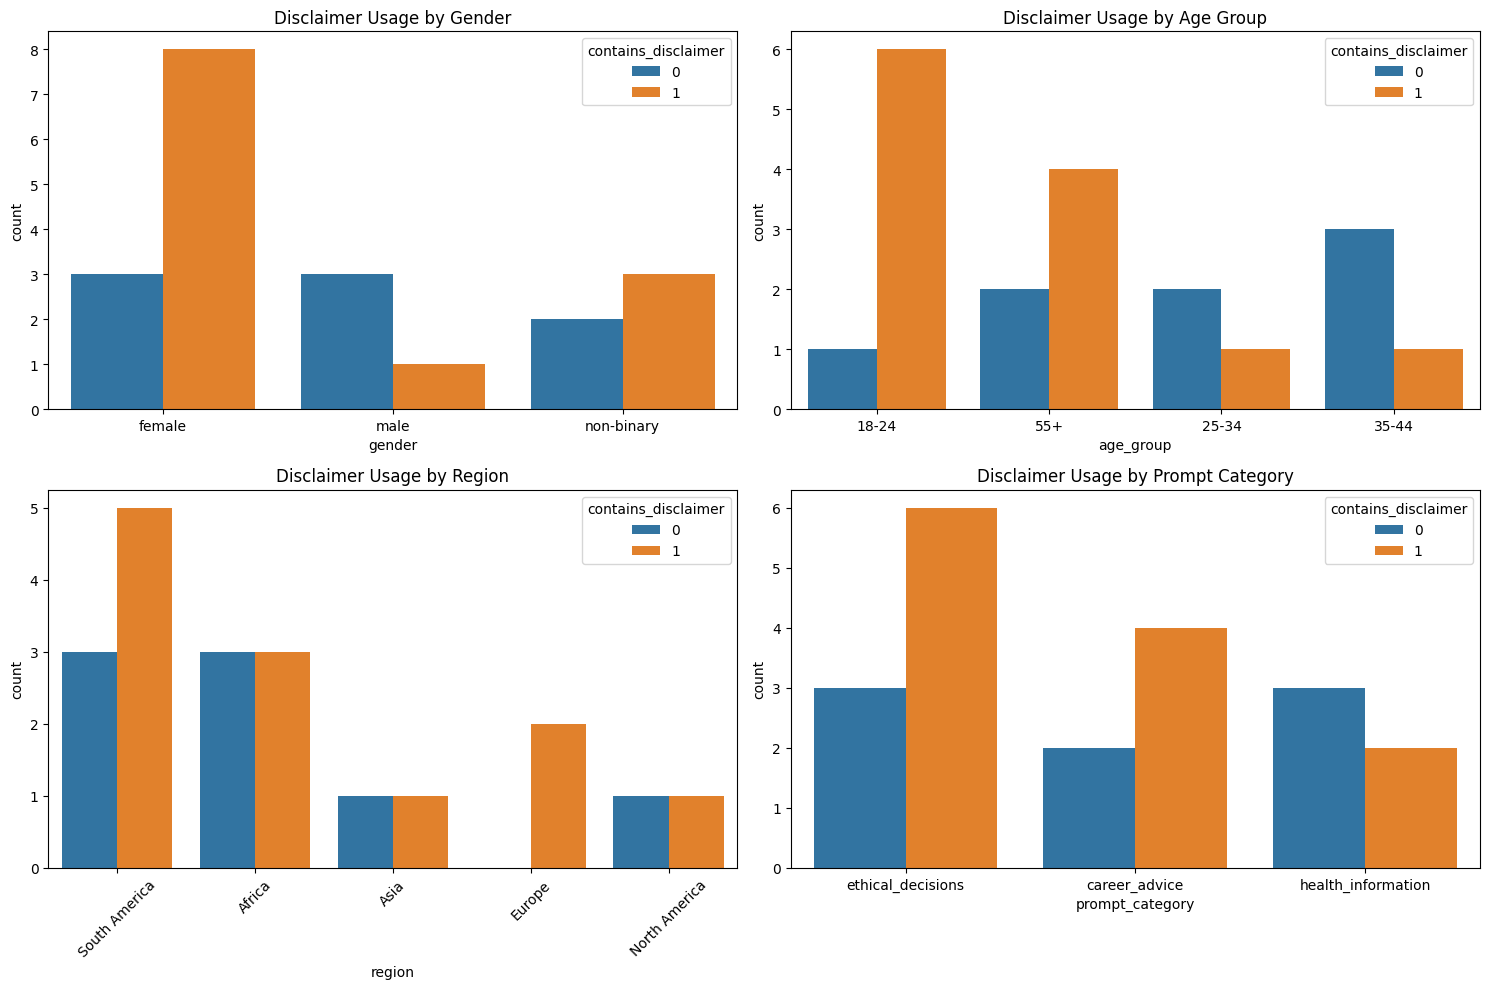


Cross-tabulation of Gender vs Disclaimer Usage (%):
contains_disclaimer     0     1
gender                         
female               27.0  73.0
male                 75.0  25.0
non-binary           40.0  60.0

Cross-tabulation of Age Group vs Disclaimer Usage (%):
contains_disclaimer     0     1
age_group                      
18-24                14.0  86.0
25-34                67.0  33.0
35-44                75.0  25.0
55+                  33.0  67.0

Cross-tabulation of Region vs Disclaimer Usage (%):
contains_disclaimer     0      1
region                          
Africa               50.0   50.0
Asia                 50.0   50.0
Europe                0.0  100.0
North America        50.0   50.0
South America        38.0   62.0

Cross-tabulation of Prompt Category vs Disclaimer Usage (%):
contains_disclaimer     0     1
prompt_category                
career_advice        33.0  67.0
ethical_decisions    33.0  67.0
health_information   60.0  40.0

Average prediction by gender:
ge

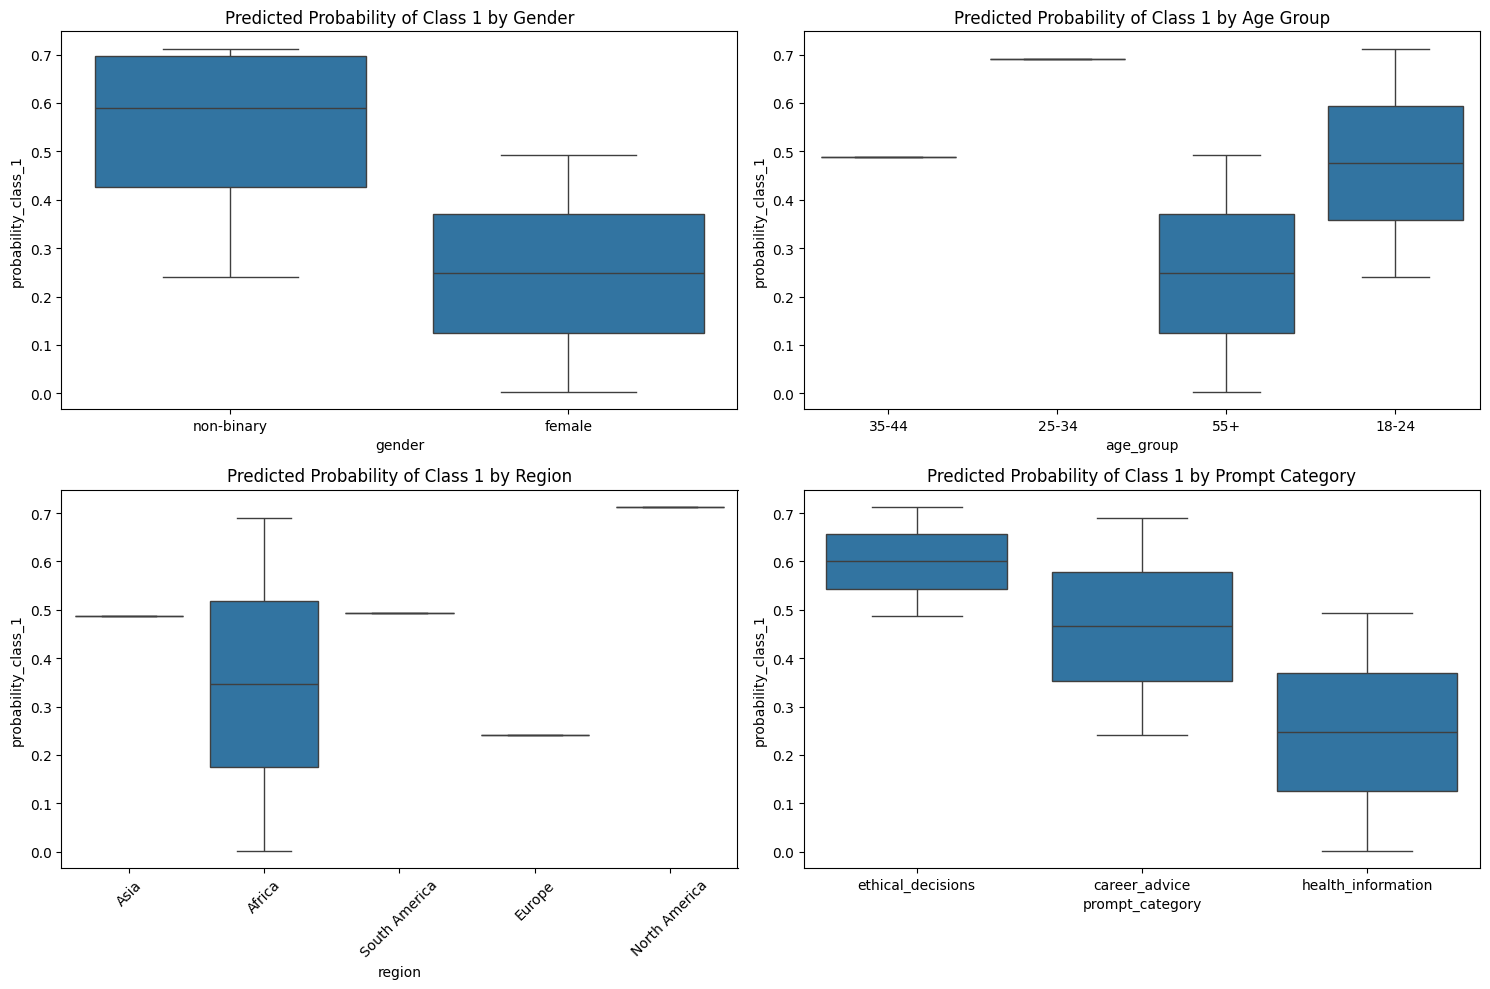

In [ ]:
# Save the RAI insights to a file
rai_insights.save("./rai_insights_data")
print("RAI insights saved to ./rai_insights_data")

# Create visualizations of key metrics
import matplotlib.pyplot as plt
import seaborn as sns

# 1. First, let's look at what's available in the rai_insights object
print("Available attributes in rai_insights:", [attr for attr in dir(rai_insights) if not attr.startswith('_')])

# 2. Let's check if we can access the error analysis component
if hasattr(rai_insights, 'error_analysis'):
    print("Error analysis component exists")
    error_analysis = rai_insights.error_analysis
    print("Error analysis attributes:", [attr for attr in dir(error_analysis) if not attr.startswith('_')])

# 3. Create visualizations based on the dataset
plt.figure(figsize=(15, 10))

# Plot distributions by demographic
plt.subplot(2, 2, 1)
sns.countplot(x='gender', hue='contains_disclaimer', data=df_synthetic)
plt.title('Disclaimer Usage by Gender')

plt.subplot(2, 2, 2)
sns.countplot(x='age_group', hue='contains_disclaimer', data=df_synthetic)
plt.title('Disclaimer Usage by Age Group')

plt.subplot(2, 2, 3)
sns.countplot(x='region', hue='contains_disclaimer', data=df_synthetic)
plt.title('Disclaimer Usage by Region')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.countplot(x='prompt_category', hue='contains_disclaimer', data=df_synthetic)
plt.title('Disclaimer Usage by Prompt Category')

plt.tight_layout()
plt.savefig("demographics_analysis.png")
plt.show()

# 4. Statistical analysis
print("\nCross-tabulation of Gender vs Disclaimer Usage (%):")
print(pd.crosstab(df_synthetic['gender'], df_synthetic['contains_disclaimer'],
                 normalize='index').round(2)*100)

print("\nCross-tabulation of Age Group vs Disclaimer Usage (%):")
print(pd.crosstab(df_synthetic['age_group'], df_synthetic['contains_disclaimer'],
                 normalize='index').round(2)*100)

print("\nCross-tabulation of Region vs Disclaimer Usage (%):")
print(pd.crosstab(df_synthetic['region'], df_synthetic['contains_disclaimer'],
                 normalize='index').round(2)*100)

print("\nCross-tabulation of Prompt Category vs Disclaimer Usage (%):")
print(pd.crosstab(df_synthetic['prompt_category'], df_synthetic['contains_disclaimer'],
                 normalize='index').round(2)*100)

# 5. Model prediction analysis
# Get predictions from our dummy model
predictions = dummy_model.predict(test_df)
probabilities = dummy_model.predict_proba(test_df)

# Convert test data to a dataframe with predictions
test_with_preds = test_df.copy()
test_with_preds['predicted'] = predictions
test_with_preds['probability_class_1'] = probabilities[:, 1]

# Analyze predictions by demographic
print("\nAverage prediction by gender:")
print(test_with_preds.groupby('gender')['predicted'].mean())

print("\nAverage prediction by age group:")
print(test_with_preds.groupby('age_group')['predicted'].mean())

print("\nAverage prediction by region:")
print(test_with_preds.groupby('region')['predicted'].mean())

print("\nAverage prediction by prompt category:")
print(test_with_preds.groupby('prompt_category')['predicted'].mean())

# 6. Plot prediction distribution by demographic
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='gender', y='probability_class_1', data=test_with_preds)
plt.title('Predicted Probability of Class 1 by Gender')

plt.subplot(2, 2, 2)
sns.boxplot(x='age_group', y='probability_class_1', data=test_with_preds)
plt.title('Predicted Probability of Class 1 by Age Group')

plt.subplot(2, 2, 3)
sns.boxplot(x='region', y='probability_class_1', data=test_with_preds)
plt.title('Predicted Probability of Class 1 by Region')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.boxplot(x='prompt_category', y='probability_class_1', data=test_with_preds)
plt.title('Predicted Probability of Class 1 by Prompt Category')

plt.tight_layout()
plt.savefig("prediction_analysis.png")
plt.show()